## Importing Required Libraries

This cell imports all the necessary Python libraries used in building and evaluating the linear regression model.  
Pandas and NumPy are used for data manipulation and numerical operations.  
Scikit-learn provides tools for preprocessing, model construction, training, and evaluation.  
Matplotlib is used for data visualization.

In [132]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt


## Loading the Dataset

This cell loads the Adidas US Sales dataset from a local Excel file into a Pandas DataFrame.  
The dataset contains sales, pricing, product, regional, and operational information that will be used to train the regression model.


In [133]:
df = pd.read_excel("Adidas_US_Sales_Datasets.xlsx")

## Dataset Inspection

This cell displays the structure and summary statistics of the dataset.  
The `.info()` method shows data types and missing values, while `.describe()` provides basic statistical information for numerical columns.  
This step helps verify data integrity before preprocessing.


In [134]:
df.head()

,Retailer,Retailer ID,Invoice Date,Region,State,City,Product,Price per Unit,Units Sold,Total Sales,Operating Profit,Operating Margin,Sales Method
0,Foot Locker,1185732,1/1/2020,Northeast,New York,New York,Men's Street Footwear,$50.00,"1,200","$600,000","$300,000",50%,In-store
1,Foot Locker,1185732,1/2/2020,Northeast,New York,New York,Men's Athletic Footwear,$50.00,"1,000","$500,000","$150,000",30%,In-store
2,Foot Locker,1185732,1/3/2020,Northeast,New York,New York,Women's Street Footwear,$40.00,"1,000","$400,000","$140,000",35%,In-store
3,Foot Locker,1185732,1/4/2020,Northeast,New York,New York,Women's Athletic Footwear,$45.00,850,"$382,500","$133,875",35%,In-store
4,Foot Locker,1185732,1/5/2020,Northeast,New York,New York,Men's Apparel,$60.00,900,"$540,000","$162,000",30%,In-store


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9648 entries, 0 to 9647
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Retailer          9648 non-null   object
 1   Retailer ID       9648 non-null   int64 
 2   Invoice Date      9648 non-null   object
 3   Region            9648 non-null   object
 4   State             9648 non-null   object
 5   City              9648 non-null   object
 6   Product           9648 non-null   object
 7   Price per Unit    9648 non-null   object
 8   Units Sold        9648 non-null   object
 9   Total Sales       9648 non-null   object
 10  Operating Profit  9648 non-null   object
 11  Operating Margin  9648 non-null   object
 12  Sales Method      9648 non-null   object
dtypes: int64(1), object(12)
memory usage: 980.0+ KB


In [136]:
df.describe()


,Retailer ID
count,9.648000e+03
mean,1.173850e+06
std,2.636038e+04
min,1.128299e+06
25%,1.185732e+06
50%,1.185732e+06
75%,1.185732e+06
max,1.197831e+06


## Feature Engineering: Date Processing

This cell converts the Invoice Date column into a datetime format and extracts the month.  
The extracted Month feature is used to capture potential seasonal patterns in sales behavior.

In [137]:
df["Invoice Date"] = pd.to_datetime(df["Invoice Date"])
df["Month"] = df["Invoice Date"].dt.month


## Data Cleaning and Transformation

This cell cleans monetary and percentage-based columns.  
Currency symbols and commas are removed from sales-related columns, and percentage symbols are removed from the operating margin.  
All cleaned columns are converted into numeric data types to ensure compatibility with machine learning algorithms.


In [138]:
# Clean currency columns
currency_cols = [
    "Price per Unit",
    "Total Sales",
    "Operating Profit"
]

for col in currency_cols:
    df[col] = (
        df[col]
        .replace(r'[\$,]', '', regex=True)
        .astype(float)
    )

# Clean percentage column
df["Operating Margin"] = (
    df["Operating Margin"]
    .replace('%', '', regex=True)
    .astype(float)
)


In [139]:
df[currency_cols + ["Operating Margin"]].dtypes


Price per Unit      float64
Total Sales         float64
Operating Profit    float64
Operating Margin    float64
dtype: object

## Defining Independent and Dependent Variables

This cell defines the feature matrix (X) and the target variable (y).  
Total Sales is selected as the dependent variable, while pricing, operational, product, regional, and temporal features are used as predictors.  
Variables that directly compute Total Sales are excluded to avoid data leakage. Such as Units Sold and Price per Uni. 
Since the formula to get Total Sales is Total Sales=Units Sold×Price per Unit

In [140]:
X = df[
    [
        "Price per Unit",
        "Operating Margin",
        "Product",
        "Region",
        "Retailer",
        "Sales Method",
        "Month"
    ]
]

y = df["Total Sales"]


## Data Preprocessing Pipeline

This cell defines the preprocessing steps applied to the dataset.  
Numerical features are passed through without modification, while categorical features are transformed using one-hot encoding.  
The encoder is configured to ignore unseen categories to allow flexible testing with new inputs.


In [141]:
from sklearn.preprocessing import StandardScaler

numeric_features = [
    "Price per Unit",
    "Operating Margin",
    "Month"
]

categorical_features = [
    "Product",
    "Region",
    "Retailer",
    "Sales Method"
]

preprocessor = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(
                steps=[
                    ("scaler", StandardScaler())
                ]
            ),
            numeric_features
        ),
        (
            "cat",
            OneHotEncoder(drop="first", handle_unknown="ignore"),
            categorical_features
        )
    ]
)


## Model Construction and Training

This cell builds a machine learning pipeline that combines preprocessing and linear regression into a single workflow.  
The model is trained using the training dataset, ensuring that preprocessing steps are consistently applied during learning.


In [142]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=123
)


## Model Construction and Training

This cell builds a machine learning pipeline that combines preprocessing and linear regression into a single workflow.  
The model is trained using the training dataset, ensuring that preprocessing steps are consistently applied during learning.


In [143]:
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", LinearRegression())
    ]
)

model.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Model Evaluation Metrics

This cell evaluates the trained model using Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R² score.  
These metrics quantify prediction accuracy, penalize large errors, and measure how well the model explains variations in total sales.


In [144]:
import numpy as np

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R² Score:", r2)

MAE: 76556.46201207295
RMSE: 106200.20194934374
R² Score: 0.4425561689284665


## Actual vs Predicted Sales Visualization

This cell generates a scatter plot comparing actual total sales values with predicted values.  
The plot provides a visual assessment of model accuracy and highlights patterns such as underestimation or overestimation.


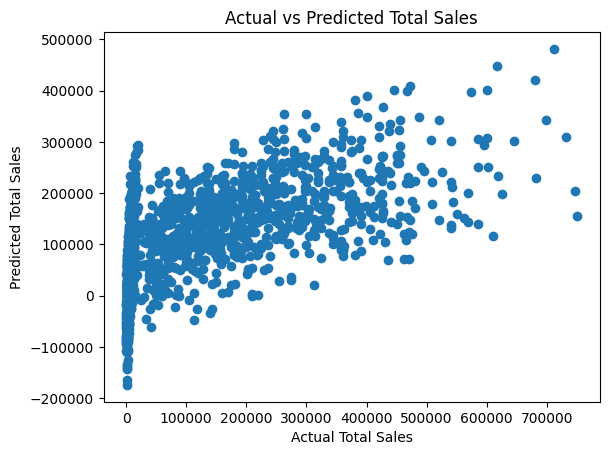

In [145]:
plt.figure()
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Total Sales")
plt.ylabel("Predicted Total Sales")
plt.title("Actual vs Predicted Total Sales")
plt.show()


The scatter plot illustrates the relationship between the actual total sales values and the corresponding values predicted by the linear regression model. Each point represents an individual observation from the test dataset, with the x-axis showing the actual total sales and the y-axis showing the predicted total sales.

The plot reveals a general upward trend, indicating a positive correlation between actual and predicted values. This suggests that the model is able to capture the overall direction and magnitude of sales behavior. However, the points are widely dispersed around the ideal diagonal line, indicating variability in prediction accuracy across different sales levels.

At lower actual sales values, the predictions exhibit a larger spread, including some negative predicted values, which suggests underfitting and limitations of the linear model in capturing low-volume sales patterns. At higher sales values, the model tends to underpredict extreme observations, as evidenced by predictions clustering below the highest actual sales values.

Overall, the scatter distribution confirms moderate predictive performance, consistent with the obtained R² score of approximately 0.44. The model captures general trends in total sales but struggles with precision, particularly for extreme and highly variable sales instances.

## Model Interpretation: Feature Coefficients

This cell extracts and displays the coefficients of the linear regression model.  
The coefficients indicate how each feature influences total sales, helping interpret which factors have positive or negative impacts.


In [146]:
feature_names = model.named_steps["preprocessor"].get_feature_names_out()
coefficients = model.named_steps["regressor"].coef_

coef_df = (
    pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": coefficients
    })
    .sort_values(by="Coefficient", ascending=False)
)

coef_df


,Feature,Coefficient
4,cat__Product_Men's Street Footwear,91905.114154
0,num__Price per Unit,67147.564441
9,cat__Region_South,50473.905685
3,cat__Product_Men's Athletic Footwear,49550.475387
7,cat__Product_Women's Street Footwear,49183.851615
5,cat__Product_Women's Apparel,44456.873189
6,cat__Product_Women's Athletic Footwear,38022.961552
13,cat__Retailer_Kohl's,20662.479704
10,cat__Region_Southeast,18073.614943
14,cat__Retailer_Sports Direct,9182.599021


## Manual Prediction Using Sample Input

This cell demonstrates how the trained model can be used to predict total sales for a single, manually defined scenario.  
It simulates a realistic sales case by specifying product, region, pricing, and sales method.


In [147]:
test_input = pd.DataFrame({
    "Price per Unit": [25.0],
    "Operating Margin": [40.0],
    "Month": [6],
    "Product": ["Men's Street Footwear"],
    "Region": ["West"],
    "Retailer": ["Foot Locker"],
    "Sales Method": ["In-store"]
})

model.predict(test_input)


array([130164.95140541])

## Interactive User Input Testing

This cell allows users to manually input sales parameters through the terminal.  
The provided values are converted into a DataFrame and passed to the trained model to generate a real-time sales prediction.


In [148]:
price = float(input("Enter Price per Unit: "))
margin = float(input("Enter Operating Margin (%): "))
month = int(input("Enter Month (1-12): "))
product = input("Enter Product: ")
region = input("Enter Region: ")
retailer = input("Enter Retailer: ")
sales_method = input("Enter Sales Method: ")

user_input = pd.DataFrame({
    "Price per Unit": [price],
    "Operating Margin": [margin],
    "Month": [month],
    "Product": [product],
    "Region": [region],
    "Retailer": [retailer],
    "Sales Method": [sales_method]
})

prediction = model.predict(user_input)
print(f"Predicted Total Sales: {prediction[0]:,.2f}")


Predicted Total Sales: 198,616.35


## Comparative Prediction Analysis

This cell compares predicted total sales across different regions while keeping other variables constant.  
The comparison highlights how regional differences affect predicted sales outcomes and supports decision-making analysis.


In [152]:
comparison_df = pd.DataFrame({
    "Price per Unit": [50, 50, 50],
    "Operating Margin": [50, 50, 50],
    "Month": [1, 1, 1],
    "Product": ["Men's Street Footwear"] * 3,
    "Region": ["Northeaast", "East", "South"],
    "Retailer": ["Foot Locker"] * 3,
    "Sales Method": ["In-store"] * 3
})

comparison_df["Predicted Sales"] = model.predict(comparison_df)
comparison_df


c:\Users\hacke\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,Price per Unit,Operating Margin,Month,Product,Region,Retailer,Sales Method,Predicted Sales
0,50,50,1,Men's Street Footwear,Northeaast,Foot Locker,In-store,241910.165460
1,50,50,1,Men's Street Footwear,East,Foot Locker,In-store,241910.165460
2,50,50,1,Men's Street Footwear,South,Foot Locker,In-store,292384.071145


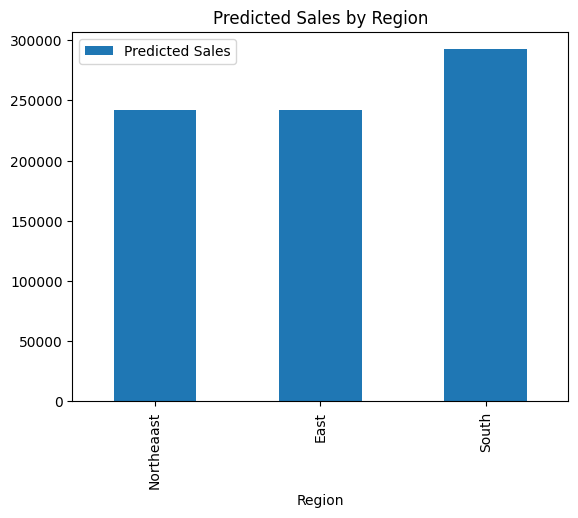

In [153]:
comparison_df.plot(
    x="Region",
    y="Predicted Sales",
    kind="bar",
    title="Predicted Sales by Region"
)
plt.show()
